## Liquid helium Notebook
------
To run on NERSC:

module load python

source activate lims-test

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import darklim

%matplotlib inline

1-fold coincidence:
integral from 0.0001 to 0.5 keV = 4.13e+04 evts/day
= 4.78e-01 evts/s
 
2-fold coincidence:
integral from 0.0001 to 0.5 keV = 1.49e+00 evts/day
= 1.73e-05 evts/s
 
3-fold coincidence:
integral from 0.0001 to 0.5 keV = 3.58e-05 evts/day
= 4.15e-10 evts/s
 
4-fold coincidence:
integral from 0.0001 to 0.5 keV = 4.30e-10 evts/day
= 4.98e-15 evts/s
 


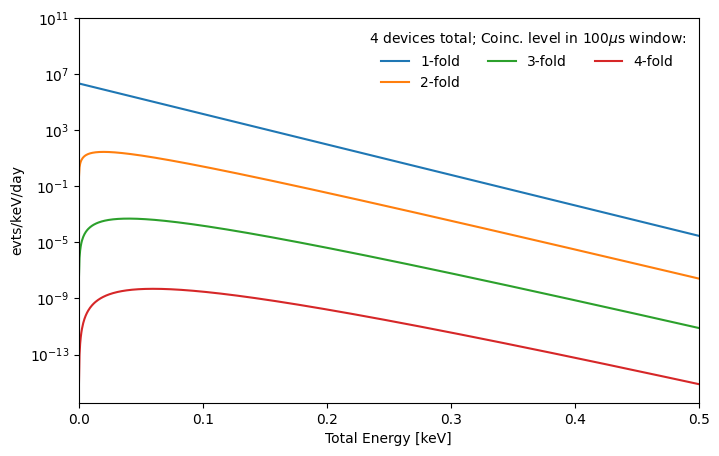

In [2]:
# test the nfold LEE function

fig, ax = plt.subplots(1,figsize=(8,5))

bins = np.linspace(0.0001,0.5,1000)

n_devices = 4
coinc = np.arange(1,5)
window = 100e-6# s
for n in coinc:
    
    print('{}-fold coincidence:'.format(n))
    model = darklim.sensitivity.n_fold_lee(bins,m=n_devices,n=n,w=window)
    
    integral = np.trapz(model,x=bins)
    print('integral from {} to {} keV = {:.2e} evts/day'.format(bins[0],bins[-1],integral))
    print('= {:0.2e} evts/s'.format(integral/24/3600))
    print(' ')
    
    plt.plot(bins,model,label='{:d}-fold'.format(n))

#lhe_mass = 0.010 # kg
#ax.axhline(1*lhe_mass,label='1 DRU in 10g LHe'.format(n),color='black',ls='--') # 1 DRU=1 evt/keV/d/kg
#plt.plot(bins,
    
ax.set_ylabel('evts/keV/day')
ax.set_xlabel('Total Energy [keV]')
ax.set_xlim(0,0.5)
ax.set_yscale('log')
ax.set_ylim(None,1e11)
ax.legend(loc='upper right',frameon=False,title='{:d} devices total;'.format(n_devices)+' Coinc. level in {:0.0f}'.format(window*1e6)+r'$\mu$s window:',ncol=3)

In [11]:
# Detector info setup

time_elapsed = 10 # days
efficiency = 1.0
tm = 'He' # target name
mass_det = 0.010 # mass in kg
energy_res = 0.373e-3 # energy resolution in keV
threshold = 5 * energy_res # threshold

n_devices = 4
coinc = 2
window = 100e-6 # s

print('detector mass is {} kg = {} g'.format(mass_det,mass_det*1000))
print('threshold = {:0.1f} eV'.format(threshold*1000))
print('assuming {:d}-fold coincidence amongst {:d} devices in a {:0.3e} s window'.format(coinc,n_devices,window))

detector mass is 0.01 kg = 10.0 g
threshold = 1.9 eV
assuming 2-fold coincidence amongst 4 devices in a 1.000e-04 s window


expect 15.0 evts
created 11.0 evts


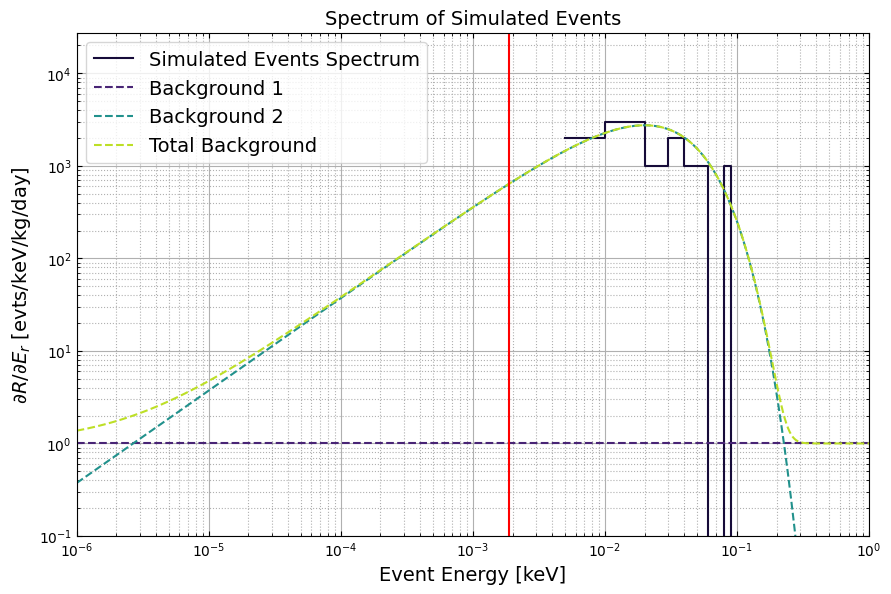

In [12]:
SE = darklim.sensitivity.SensEst(mass_det, time_elapsed, eff=efficiency, tm=tm)

SE.reset_sim()

SE.add_flat_bkgd(1) # flat background of 1 DRU

#SE.add_nfold_lee_bkgd(m=4,n=2,w=window)
SE.add_nfold_lee_bkgd(m=n_devices,n=coinc,w=window)

# DM background for 1 GeV dark matter with a cross section of 1e-36 cm^2
#SE.add_dm_bkgd(0.05, 1e-38)

gen_evts = SE.generate_background(1, plot_bkgd=True)
ax = plt.gca()
#plt.ylim(0.1,50)
ax.set_xscale('log')
ax.axvline(threshold,ls='-',color='red')

In the above figure, we can see the three different backgrounds, the total background, and the data generated.

Below, we'll reset the simulation, remake the backgrounds without including the DM background, and run the simulation.

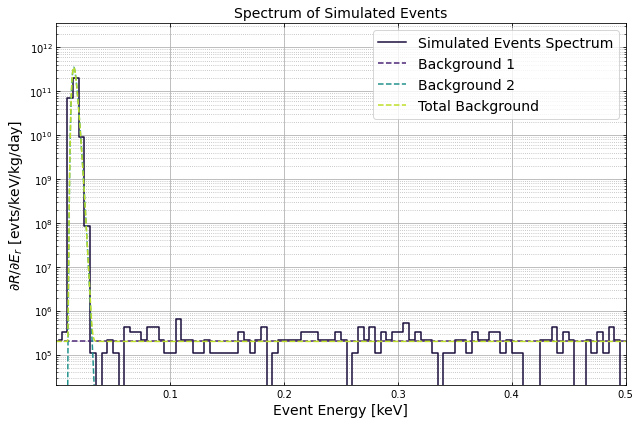

In [4]:
SE.reset_sim()

# flat background of 200000 DRU
SE.add_flat_bkgd(2e5)
# noise background assuming 1024 independent samples, using the data sample rate
SE.add_noise_bkgd(energy_res, 1024, 39062.5)

# run the simulation for 1 experiment
m_dm, sig = SE.run_sim(
    threshold,
    0.5,
    m_dms=np.geomspace(0.01, 2, num=25),
    plot_bkgd=True,
    nexp=1, # increase for a better estimate, 1 is generally used for diagnostics
)

With the simulation run, let's plot the estimated sensitivity for this (imaginary) detector.

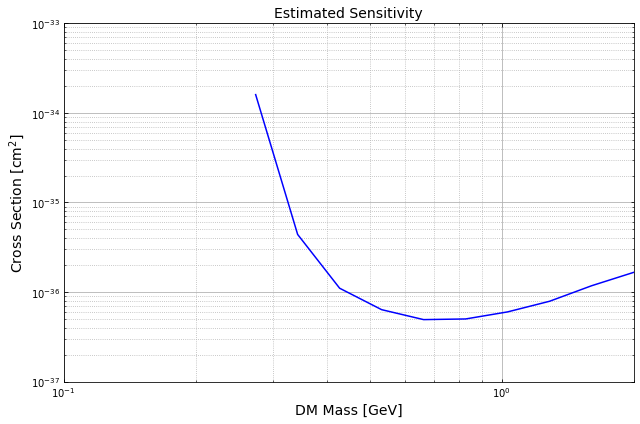

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.loglog(m_dm, sig, color='b')

ax.set_ylim(1e-37, 1e-33)
ax.set_xlim(0.1, 2)
ax.set_xlabel("DM Mass [GeV]", fontsize=14)
ax.set_ylabel("Cross Section [cm$^2$]", fontsize=14)
ax.set_title("Estimated Sensitivity", fontsize=14)

ax.grid()
ax.grid(which="minor", linestyle='dotted')
ax.tick_params(which="both", direction="in", right=True, top=True)

fig.tight_layout()